In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.mixture import GaussianMixture
plt.style.use('ggplot')

In [2]:
df = pd.read_excel('wr2018.xlsx')
df['TD/G'] = df['TD'] / df['G']

In [3]:
df.head()

,Rk,Player,Tm,Age,Pos,G,GS,Tgt,Rec,Ctch%,Yds,Y/R,TD,Lng,Y/Tgt,R/G,Y/G,Fmb,TD/G
0,1,Michael Thomas*+,NOR,25,WR,16,16,147,125,0.850,1405,11.2,9,72,9.6,7.8,87.8,2,0.5625
1,2,Zach Ertz*,PHI,28,TE,16,16,156,116,0.744,1163,10.0,8,34,7.5,7.3,72.7,1,0.5000
2,3,DeAndre Hopkins*+,HOU,26,WR,16,16,163,115,0.706,1572,13.7,11,49,9.6,7.2,98.3,2,0.6875
3,4,Julio Jones*,ATL,29,WR,16,16,170,113,0.665,1677,14.8,8,58,9.9,7.1,104.8,2,0.5000
4,5,Adam Thielen*,MIN,28,WR,16,16,153,113,0.739,1373,12.2,9,68,9.0,7.1,85.8,1,0.5625


In [4]:
df = df[df['Pos'] == 'TE']

In [5]:
df.columns

Index(['Rk', 'Player', 'Tm', 'Age', 'Pos', 'G', 'GS', 'Tgt', 'Rec', 'Ctch%',
       'Yds', 'Y/R', 'TD', 'Lng', 'Y/Tgt', 'R/G', 'Y/G', 'Fmb', 'TD/G'],
      dtype='object')

### Cluster 2018 WRs into Tiers

In [6]:
X = df[['Rk','G', 'GS', 'Tgt', 'Rec', 'Ctch%','Yds', 'Y/R', 
        'TD', 'Lng', 'Y/Tgt', 'R/G', 'Y/G', 'Fmb', 'TD/G']].values
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))
        if bic[-1] < lowest_bic and aic[-1] < lowest_aic:
            lowest_bic = bic[-1]
            lowest_aic = aic[-1]
            best_gmm = gmm
            
best_gmm.fit(X)
tier = best_gmm.predict(X)
df['tier'] = tier

In [7]:
l = []
for item in tier:
    if item not in l:
        l.append(item)
tier_ranks = []
for i in range(len(np.unique(tier))):
    tier_ranks.append((i,l[i]))
tier_ranks = sorted(tier_ranks, key=lambda tup: tup[1])
ordered_ranks = list(i+1 for i in range(len(tier_ranks)))
ordered_ranking = []
for i in tier:
    loc = l.index(i)
    ordered_ranking.append(ordered_ranks[loc])
    
df['tier'] = ordered_ranking

In [8]:
df['tier_min_y/g'] = df.groupby('tier')['Y/G'].transform('min')
df['tier_avg_y/g'] = df.groupby('tier')['Y/G'].transform('mean')
df['tier_max_y/g'] = df.groupby('tier')['Y/G'].transform('max')
df['tier_min_td/g'] = df.groupby('tier')['TD/G'].transform('min')
df['tier_avg_td/g'] = df.groupby('tier')['TD/G'].transform('mean')
df['tier_max_td/g'] = df.groupby('tier')['TD/G'].transform('max')

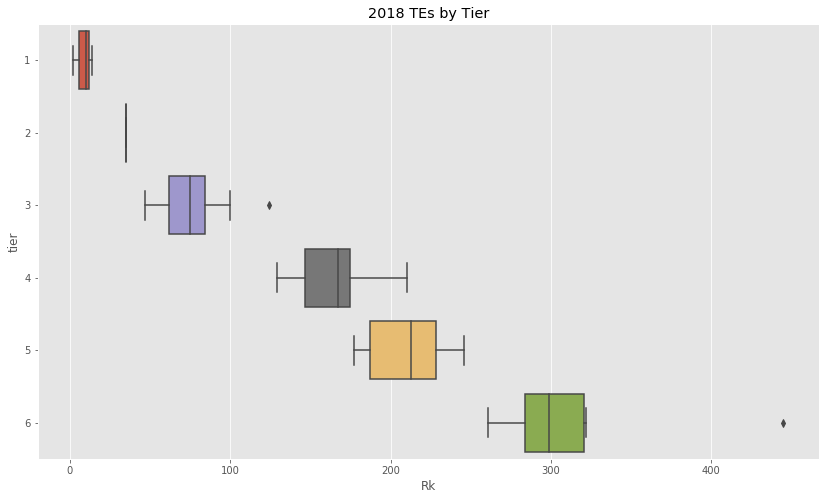

In [9]:
plt.figure(figsize=(14,8))
plt.title("2018 TEs by Tier")
ax = sns.boxplot(data=df, x='Rk', y='tier', orient="h")

### Upload Week 1 Rankings

In [10]:
df2 = pd.read_csv('2019_wk_1_te.csv')
df2 = df2.drop(['Tier','WSIS'],axis=1)

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 8 columns):
Rank          102 non-null float64
Tight Ends    102 non-null object
Team          102 non-null object
Opp           99 non-null object
Best          102 non-null float64
Worst         102 non-null float64
Avg           102 non-null float64
Std Dev       102 non-null float64
dtypes: float64(5), object(3)
memory usage: 6.6+ KB


In [12]:
df2.tail()

,Rank,Tight Ends,Team,Opp,Best,Worst,Avg,Std Dev
99,100.0,Joshua Perkins,PHI,vs. WAS,90.0,90.0,90.0,0.0
100,101.0,Sean Culkin,LAC,vs. IND,97.0,97.0,97.0,0.0
101,102.0,Johnny Mundt,LAR,at CAR,102.0,104.0,103.0,1.0
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df2 = df2[0:102]

In [14]:
X = df2[['Rank','Best', 'Worst', 'Avg','Std Dev']].values
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))
        if bic[-1] < lowest_bic and aic[-1] < lowest_aic:
            lowest_bic = bic[-1]
            lowest_aic = aic[-1]
            best_gmm = gmm
best_gmm.fit(X)
tier = best_gmm.predict(X)
df2['tier'] = tier

l = []
for item in tier:
    if item not in l:
        l.append(item)

tier_ranks = []
for i in range(len(np.unique(tier))):
    tier_ranks.append((i,l[i]))
tier_ranks = sorted(tier_ranks, key=lambda tup: tup[1])    
ordered_ranks = list(i+1 for i in range(len(tier_ranks)))
ordered_ranking = []
for i in tier:
    loc = l.index(i)
    ordered_ranking.append(ordered_ranks[loc])
df2['tier'] = ordered_ranking

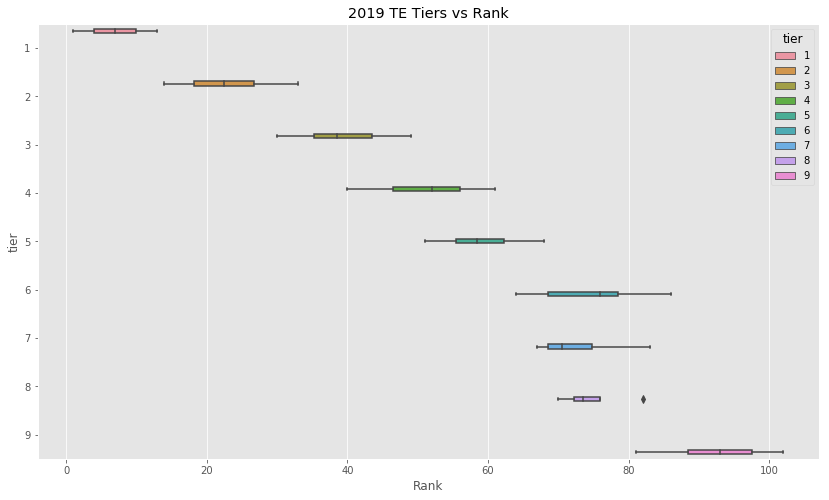

In [15]:
plt.figure(figsize=(14,8))
plt.title("2019 TE Tiers vs Rank")
ax = sns.boxplot(data=df2, x='Rank', y='tier', hue='tier', orient="h")

### Use the 2018 Tier Stats to Create Fantasy Point Projection Ranges

In [16]:
final = df.drop_duplicates('tier')
final = final[['tier','tier_min_y/g','tier_avg_y/g','tier_max_y/g',
               'tier_min_td/g', 'tier_avg_td/g','tier_max_td/g']]

In [17]:
final['fp_min'] = (final['tier_min_y/g'] / 10) + (final['tier_min_td/g'] * 6) 
final['fp_avg'] = (final['tier_avg_y/g'] / 10) + (final['tier_avg_td/g'] * 6) 
final['fp_max'] = (final['tier_max_y/g'] / 10) + (final['tier_max_td/g'] * 6) 
final = final.reset_index(drop=True)

In [18]:
proj = pd.DataFrame(columns=['Tight Ends','Team','Opp'])
for t in final.tier.values:
    temp = df2[df2['tier'] == t]
    temp = temp.reset_index(drop=True)
    temp['fp_min'] = final.loc[t-1]['fp_min']
    temp['fp_avg'] = final.loc[t-1]['fp_avg']
    temp['fp_max'] = final.loc[t-1]['fp_max']
    proj = pd.concat([proj,temp],sort=False)

In [19]:
proj = proj[['Tight Ends', 'Team', 'Opp', 'tier', 'fp_min', 'fp_avg', 'fp_max']]
proj = proj.reset_index(drop=True)

In [20]:
proj.head()

,Tight Ends,Team,Opp,tier,fp_min,fp_avg,fp_max
0,Travis Kelce,KC,at JAC,1.0,9.145,10.951667,12.36
1,George Kittle,SF,at TB,1.0,9.145,10.951667,12.36
2,Zach Ertz,PHI,vs. WAS,1.0,9.145,10.951667,12.36
3,O.J. Howard,TB,vs. SF,1.0,9.145,10.951667,12.36
4,Hunter Henry,LAC,vs. IND,1.0,9.145,10.951667,12.36


In [21]:
proj.to_csv('te_wk1_proj.csv',index=False)